## Homework

### Imports

In [1]:
import os
from typing import List

import joblib
import matplotlib.pyplot as plt
import polars as pl
import sqlalchemy
from pgvector.sqlalchemy import Vector
from PIL import Image
from sentence_transformers import SentenceTransformer
from sqlalchemy import Integer, String, create_engine
from sqlalchemy.engine import URL
from sqlalchemy.orm import DeclarativeBase, Mapped, Session, mapped_column
from tqdm.notebook import tqdm


### Paths and consts

In [2]:
DEVICE = "cpu"

In [3]:
METADATA_PATH = os.path.join(
    "data", "abo-images-small", "images", "metadata", "images.csv"
)

IMAGES_PATH = os.path.join(
    "data",
    "abo-images-small",
    "images",
    "small",
)

### 1. Dataset preparation

In [4]:
def extract_image_paths(metadata_path: str, min_pixes: int = 1000) -> List[str]:
    metadata_df = pl.read_csv(metadata_path)

    return (
        metadata_df.filter(
            (pl.col("height") >= min_pixes) & (pl.col("width") >= min_pixes)
        )
        .with_columns(
            (pl.lit(os.path.join(IMAGES_PATH, "")) + pl.col("path")).alias("path")
        )
        .get_column("path")
        .to_list()
    )

In [5]:
image_paths = extract_image_paths(METADATA_PATH)

print(image_paths[:3])

['data/abo-images-small/images/small/46/4689906d.png', 'data/abo-images-small/images/small/0c/0cd7596c.jpg', 'data/abo-images-small/images/small/e6/e602a9af.jpg']


### 2. Model Selection and Understanding

**vector length**: 512

**model_type**: Model uses a ViT-B/32 Transformer architecture as an image encoder and uses a masked self-attention Transformer as a text encoder.

Meaning of model name:
- **vit** - means Vision Transformer
- **B** - Base version of model -> medium amount of parameters
- **32** - Patch size 32x32 - 32x32 is single 'token' for model

### 3. Database Setup

Using db from lab

In [6]:
db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5432,
    database="similarity_search_service_db",
)

In [7]:
class Base(DeclarativeBase):
    __abstract__ = True


class Img(Base):
    __tablename__ = "images"
    VECTOR_LENGTH = 512

    id: Mapped[int] = mapped_column(Integer, primary_key=True)
    image_path: Mapped[str] = mapped_column(String(400))
    embedding: Mapped[List[float]] = mapped_column(Vector(VECTOR_LENGTH))


In [8]:
engine = create_engine(db_url)
Base.metadata.create_all(engine)

### 3. Image vectorization


In [9]:
MAX_IMAGES = 100
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

In [10]:
model = SentenceTransformer("clip-ViT-B-32", device=DEVICE)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [11]:
def batched(iterable, batch_size):
    for i in range(0, len(iterable), batch_size):
        yield iterable[i : i + batch_size]

In [41]:
def insert_images(engine, images: List[Img]):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine, model, image_paths, offest=0, max_images=MAX_IMAGES):
    with tqdm(total=max_images) as pbar:
        processed = 0
        for images_paths_batch in batched(
            image_paths[offest:], batch_size=100
        ):  # finish (suggestion - use `batched`)
            images = [Image.open(path) for path in images_paths_batch]

            # calculate embeddings
            embeddings = model.encode(images)

            # create Img instances for all images in batch
            imgs = []
            for i in range(len(images)):
                img = Img(image_path=images_paths_batch[i], embedding=embeddings[i])
                imgs.append(img)

            # insert all batch images
            insert_images(engine, imgs)

            # update pbar
            pbar.update(len(images))
            processed += len(images)

            if processed >= max_images:
                break

In [13]:
vectorize_images(engine, model, image_paths)

  0%|          | 0/100 [00:00<?, ?it/s]

### 3. Search and results display

In [15]:
class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_image_paths = self.find_similar_images(image_description, k)
        self.display_images(found_image_paths, k)

    def find_similar_images(self, image_description: str, k: int):
        desc_embedding = self.model.encode(
            image_description
        )  # calculate embedding of image_description

        # remember about session and commit
        with Session(engine) as session:
            result = session.execute(
                sqlalchemy.select(Img.image_path)
                .order_by(Img.embedding.cosine_distance(desc_embedding))
                .limit(k),
            ).scalars()

            return list(result)

    def display_images(self, image_paths, k):
        _, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(image_paths):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

In [42]:
search = ImageSearch(engine, model)

## Experiments

Experiment is to find top images based on how much imagees are saved: 100, 1000, 10000. Expectation is that for 10k the results will be the best. 

Queries were build on the existing images.

In [48]:
queries = [
    "Multicolor clock with white background",
    "Black squared table",
    "A big corner sofa, with measurements",
]


def run_experiment(k=4):
    for q in queries:
        print(f"Images for query: {q}")
        search(q, k)
        print("===" * 30)


### Experiment with only 100 images

In [49]:
vectorize_images(engine, model, image_paths, max_images=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Images for query: Multicolor clock with white background


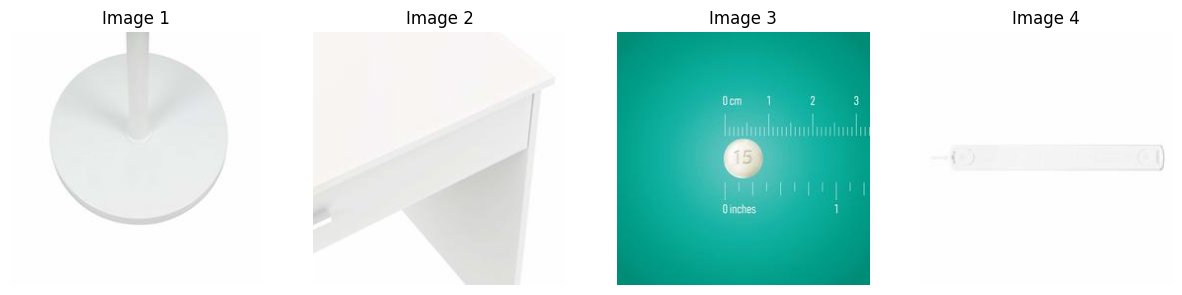

Images for query: Black squared table


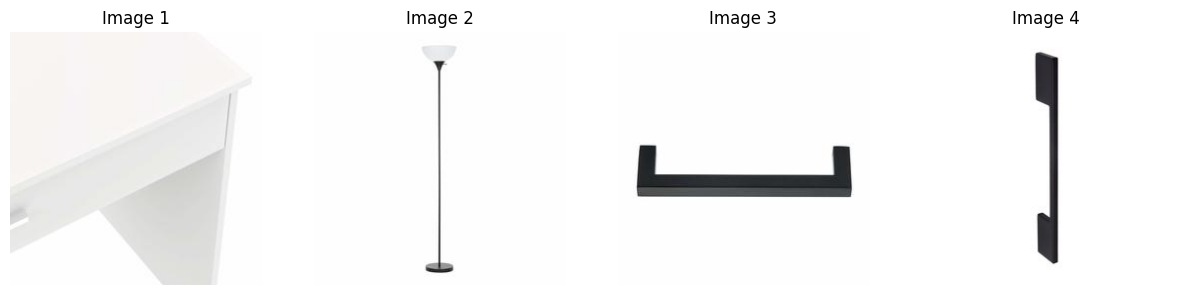

Images for query: A big corner sofa, with measurements


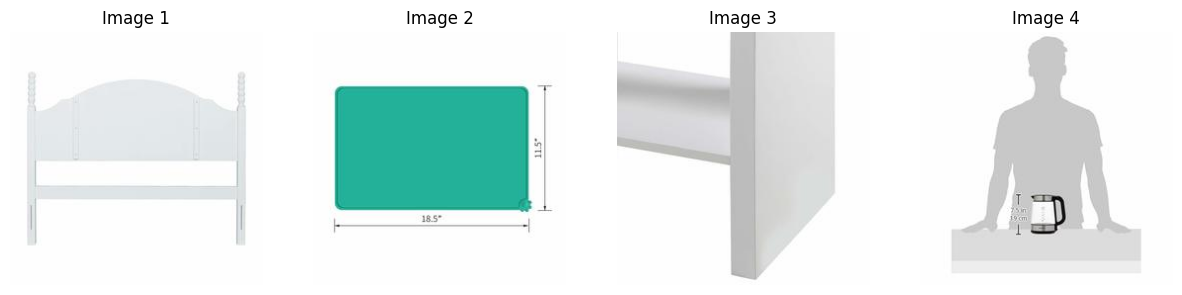

In [50]:
run_experiment()

### Experiment with 1000 images

In [51]:
vectorize_images(engine, model, image_paths, offest=100, max_images=900)

  0%|          | 0/900 [00:00<?, ?it/s]

Images for query: Multicolor clock with white background


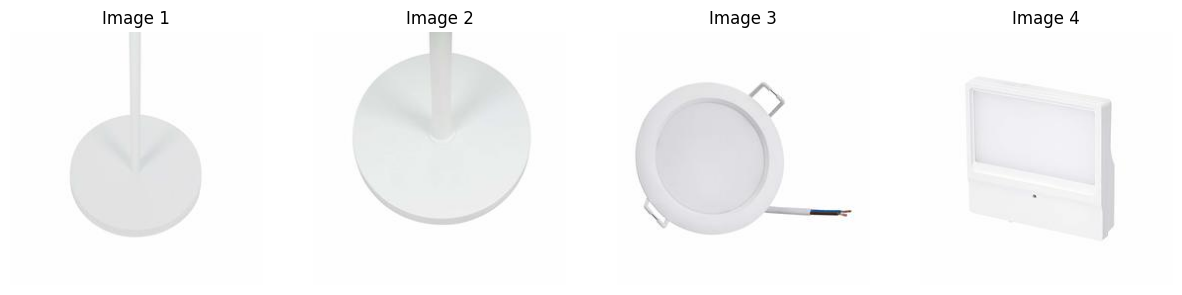

Images for query: Black squared table


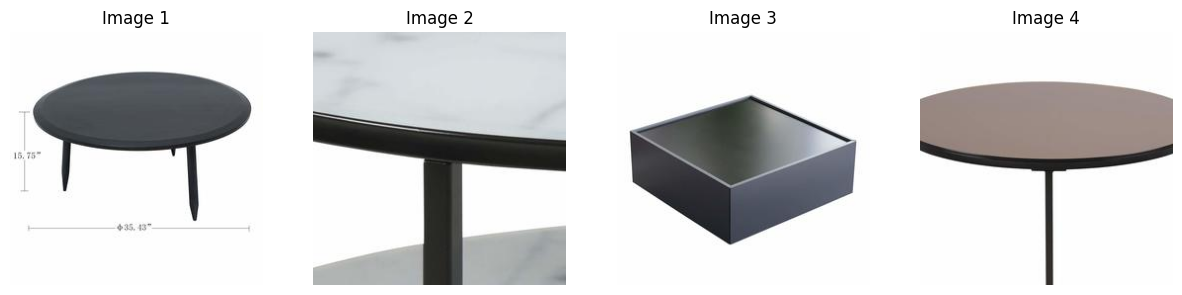

Images for query: A big corner sofa, with measurements


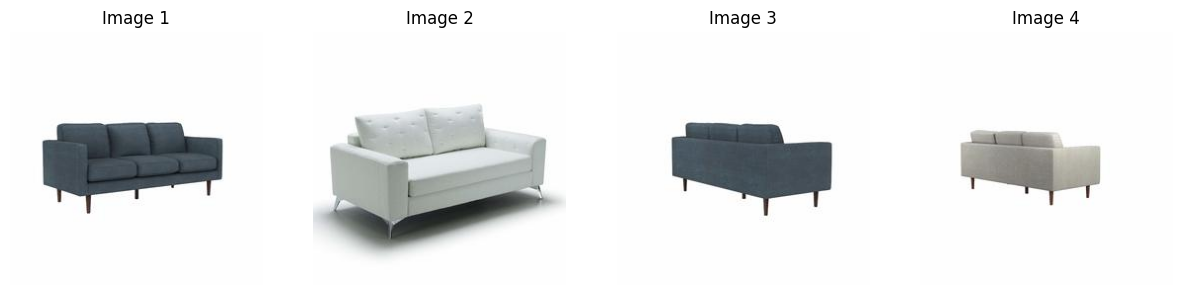

In [52]:
run_experiment()

### Experiment with 10k images

In [53]:
vectorize_images(engine, model, image_paths, offest=1000, max_images=9000)

  0%|          | 0/9000 [00:00<?, ?it/s]

Images for query: Multicolor clock with white background


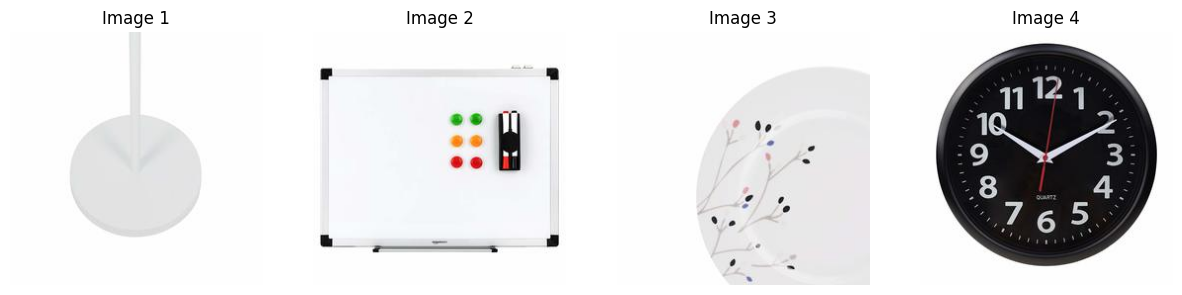

Images for query: Black squared table


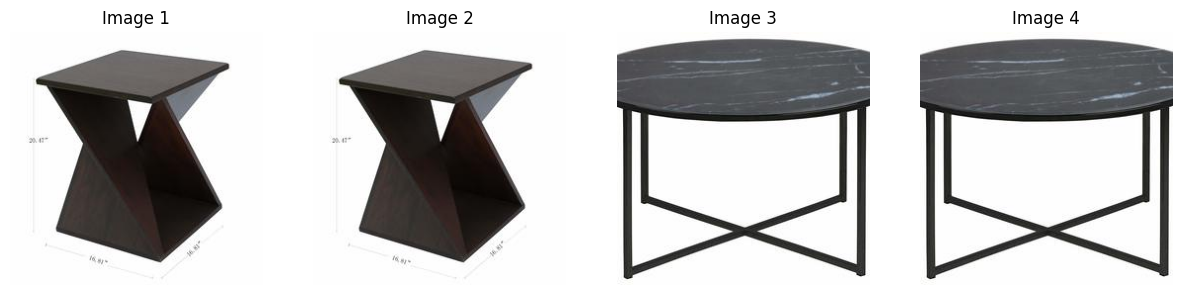

Images for query: A big corner sofa, with measurements


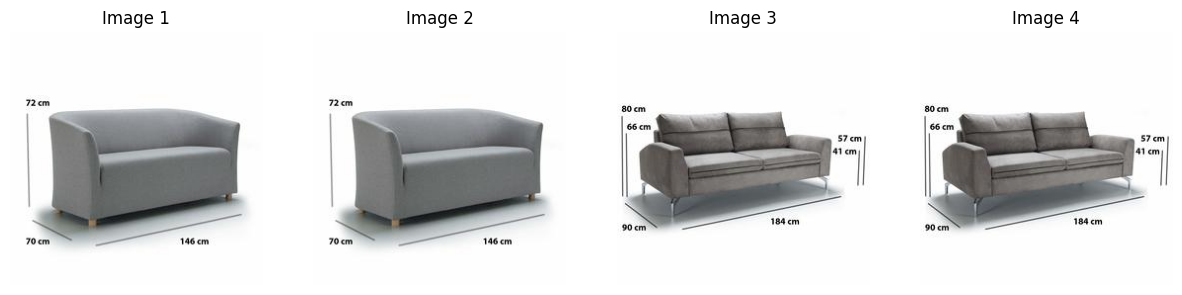

In [54]:
run_experiment()

### Conclusion for experiment

1) For 100 images, results are bad. There is high chance, that there are no images similar to queries to the images.

2) For 1000 images, results are definitely better. There are atleast items which were described in queries. However, they miss  some of the details such as color.

3) For 10k images, results are almost the same as description. There are some duplictes in the sofas. However there are cause by thata. There is no the same images in the database. Proof below

```sql
SELECT COUNT(*) FROM images i;
```


```sql
SELECT COUNT(DISTINCT i.image_path) FROM images i;
```

For both sql queries, the resutls are 10k.